In [1]:
import itertools
import os

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from handcrafted.app.dataset.dataset_loader import DatasetLoader
from handcrafted.app.dataset.utils.dataset_creator import DatasetCreator
from handcrafted.app.dataset.utils.frames_splitter import FramesSplitter
from handcrafted.app.model.model_statistics import ModelStatistics

2025-04-01 10:31:41.036579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 10:31:41.038097: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 10:31:41.061850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 10:31:41.061920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 10:31:41.062621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
loader = DatasetLoader(directory="./data/frames_no_bg/")

12023it [00:12, 966.19it/s] 


In [3]:
num_signers = 3
if num_signers == -1:
    signers = loader.signers
    num_signers = loader.num_signers
else:
    signers = dict(itertools.islice(loader.signers.items(), num_signers))

In [4]:
splitter = FramesSplitter(signers, val_split=0.3, test_split=0.3, frames_to_extract=1000, seed=42)

In [5]:
X_train, X_train_aug, y_train, X_val, X_val_aug, y_val, X_test, X_test_aug, y_test = splitter.split()

100%|██████████| 3/3 [00:00<00:00, 278.28it/s]


In [6]:
# Get the total of different labels
num_classes = loader.num_signers
print(num_classes)

78


In [7]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

In [9]:
BATCH_SIZE = 32

dataset_creator = DatasetCreator()
train_dataset = dataset_creator.create_dataset(X_train, X_train_aug, y_train_onehot, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = dataset_creator.create_dataset(X_val, X_val_aug, y_val_onehot, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = dataset_creator.create_dataset(X_test, X_test_aug, y_test_onehot, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def build_vggface():
    model = keras.Sequential(
        [
            layers.Input(shape=(224, 224, 3), name='input'),
            layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1_1-relu1_1'),
            layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1_2-relu1_2'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool1'),
            layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2_1-relu2_1'),
            layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2_2-relu2_2'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool2'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_1-relu3_1'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_2-relu3_2'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_3-relu3_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool3'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_1-relu4_1'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_2-relu4_2'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_3-relu4_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool4'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_1-relu5_1'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_2-relu5_2'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_3-relu5_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool5'),
            layers.Conv2D(filters=4096, kernel_size=7, activation='relu', name='fc6-relu6'),
            layers.Dropout(0.5, name='do6'),
            layers.Conv2D(filters=4096, kernel_size=1, activation='relu', name='fc7-relu7'),
            layers.Dropout(0.5, name='do7'),
            layers.Conv2D(filters=num_classes, kernel_size=1, activation='softmax', name='fc8-prob'),
            layers.Flatten(name='flatten'),
        ]
    )

    return model

In [11]:
def build_small_cnn(num_classes):
    model = keras.Sequential([
        layers.Input(shape=(224, 224, 3), name='input'),
        # First convolutional block
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool1'),
        # Second convolutional block
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool2'),
        # Third convolutional block
        layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool3'),
        # Flatten and dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    return model

In [12]:
strategy = tf.distribute.MirroredStrategy()
print('Number of available GPU:', strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of available GPU: 1


In [13]:
with strategy.scope():
    model = build_small_cnn(num_classes)
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=['accuracy']
    )

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# model.load_weights('vgg_face_weights.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 56, 56, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 28, 28, 128)       0         
                                                                 
 flatten (Flatten)           (None, 100352)           

In [14]:
checkpoint_filepath = "model.ckpt"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True
)

In [15]:
history = model.fit(
    train_dataset,
    epochs=2,
    # steps_per_epoch=(len(X_train) * NUM_AUG) // BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1,
)

Epoch 1/2


2025-04-01 10:31:56.882409: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


    235/Unknown - 56s 229ms/step - loss: 0.1404 - accuracy: 0.9675

2025-04-01 10:32:52.508339: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


235/235 [==============================] - 64s 264ms/step - loss: 0.1404 - accuracy: 0.9675 - val_loss: 0.0170 - val_accuracy: 0.9941
Epoch 2/2
235/235 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991

2025-04-01 10:33:55.540732: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


235/235 [==============================] - 61s 258ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0593 - val_accuracy: 0.9891


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

150/150 [==============================] - 9s 60ms/step - loss: 0.0024 - accuracy: 0.9983


In [17]:
y_pred = model.predict(test_dataset)

150/150 [==============================] - 9s 60ms/step


In [18]:
y_pred_indices = np.argmax(y_pred, axis=1)
y_pred_original = label_encoder.inverse_transform(y_pred_indices)

In [19]:
print(len(y_test))
print(len(y_pred_original))

4784
4784


In [20]:
stats = ModelStatistics(save_name=f"svc_signer_test_{len(y_test)}", save_dir="signer/plots")

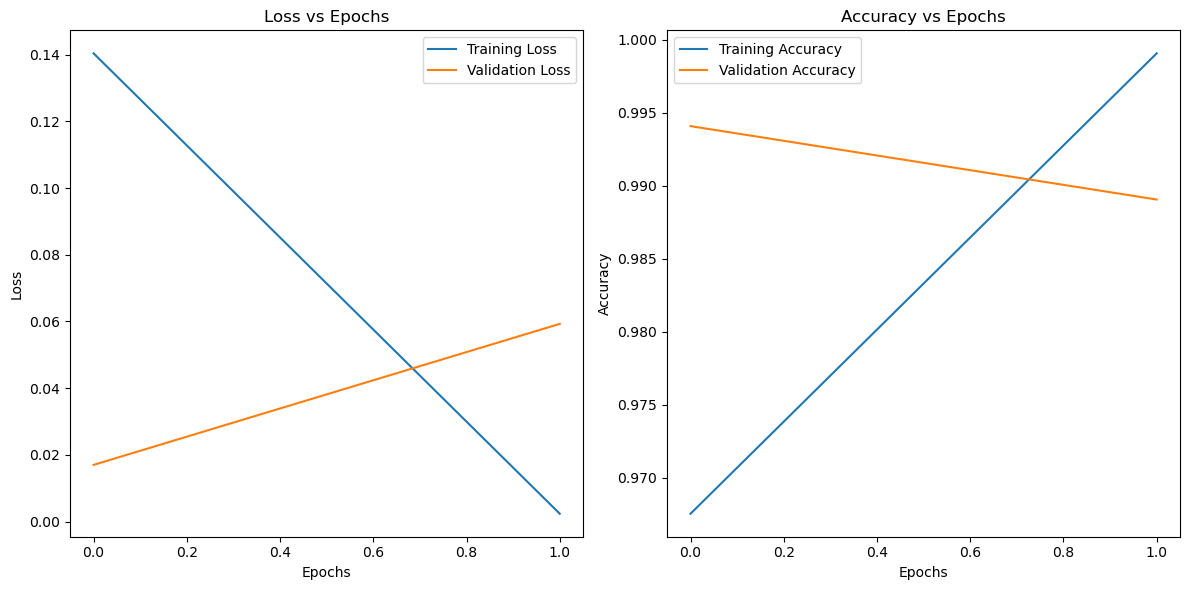

In [21]:
stats.plot_history(history=history)

Accuracy: 99.83%
Confusion matrix saved at signer/plots/svc_signer_test_4784.png


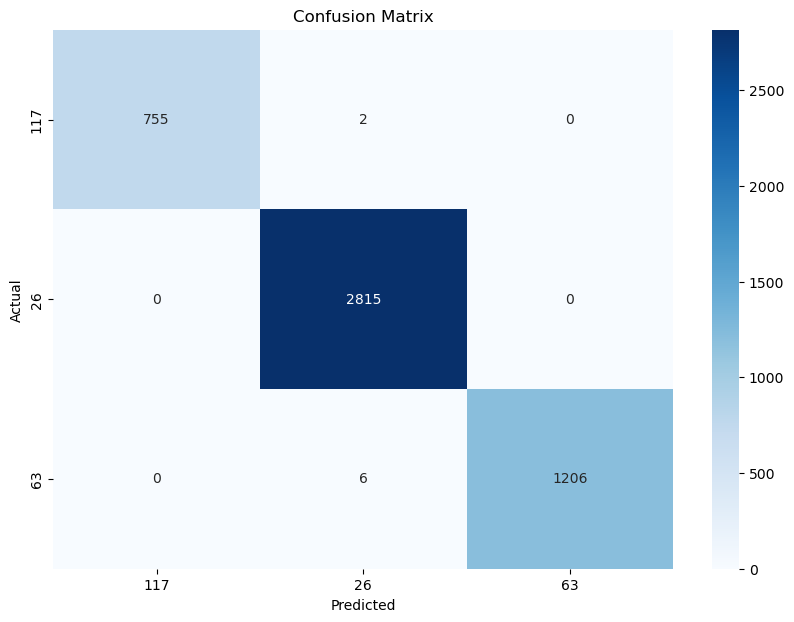

In [22]:
stats.print_accuracy(y_test, y_pred_original)
stats.plot_confusion_matrix(y_test, y_pred_original, save=True, plot=True)